# **Unsupervised Discovery and Analysis of Linguistic Personas in Movie Reviews**

# **PREREQUISITES & SETUP**
This section installs necessary libraries and configures the environment. It leverages a GPU with cuML for accelerated computation if available, otherwise, it defaults to CPU-based libraries.

In [1]:
# --- Installation of required libraries ---
!pip install better_profanity setfit bertopic kneed

# --- Core & Utility Libraries ---
import time
import pandas as pd
import numpy as np
import re
from collections import Counter
import warnings
from IPython.display import display, HTML, clear_output
import torch

# --- Machine Learning, Clustering & Feature Engineering ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, Birch, FeatureAgglomeration
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from kneed import KneeLocator # For finding the elbow/knee in a curve

# --- NLP & Embeddings ---
import spacy
from better_profanity import profanity
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.graph_objects as go
import umap.umap_ as umap

# --- Environment Configuration ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid", {'axes.grid': True, 'grid.linestyle': '--'})

# --- GPU / CPU Configuration ---
USE_GPU, CUML_AVAILABLE = torch.cuda.is_available(), False
if USE_GPU:
    print("✅ GPU detected. Attempting to use cuML for acceleration.")
    try:
        import cudf
        from cuml.cluster import KMeans as cuKMeans
        print("   -> cuML imported successfully."); CUML_AVAILABLE = True
    except ImportError:
        print("   -> ⚠️ cuML not found, even though a GPU is present. Falling back to CPU-based libraries.")
else:
    print("🔵 No GPU detected. Using CPU for all operations.")

# --- Load NLP Models ---
device = 'cuda' if USE_GPU else 'cpu'
try:
    if USE_GPU: spacy.require_gpu()
    print(f"✅ spaCy is configured for {device.upper()}.")
except Exception:
    print('🔵 spaCy is using CPU.')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print(f"✅ SentenceTransformer is configured to use: {device.upper()}")

# --- Data Loading ---
features_loaded_path = '/kaggle/input/feature-engineered-imdb-dataset/feature_engineered_imdb_data.parquet'
try:
    df = pd.read_parquet(features_loaded_path)
    print('\n✅ Using pre-feature engineered dataset.')
except Exception as e:
    print(f"\nCould not load pre-engineered dataset: {e}. Feature engineering will be required.")
    # This is a placeholder for the actual dataset path if it needs to be loaded from scratch
    # df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
    df = pd.DataFrame() # Create empty df to avoid errors if the above path is wrong

if not df.empty: display(df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.5 MB/s eta 

2025-07-26 07:42:56.341324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753515776.584102      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753515776.655430      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔵 No GPU detected. Using CPU for all operations.
✅ spaCy is configured for CPU.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ SentenceTransformer is configured to use: CPU

✅ Using pre-feature engineered dataset.


Review  Rating  Sentiment   wc  \
0  Kurt Russell's chameleon-like performance, cou...      10          1  108   
1  It was extremely low budget(it some scenes it ...       8          1  209   
2  James Cagney is best known for his tough chara...       8          1  394   
3  Following the brilliant "Goyôkiba" (aka. "Hanz...       8          1  428   
4  One of the last classics of the French New Wav...      10          1  161   

   ap  cm  em  qm  pa  nb   sl  pp  pr  im  we  yu  sr  ne        tt  \
0  25   6   0   0   2   0   22  14  10   4   0   0   4   2 -0.265487   
1  19   3   0   0   4   3   33  22  34   2   0   3   2   0 -0.378641   
2  83  10   0   0   0  15   67  40  39   1   0   0   1   5 -0.474531   
3  95  28   3   0   8  14  105  41  41   8   0   0   8   4 -0.472941   
4  40  15   0   0   6   1   48  17  12   1   0   1   1   0 -0.259259   

             mf  sw                                                 se  
0  95728.433628   1  [-0.030246966, 0.006890678, -0.042680707, -0.0...  
1  75352.694175   2  [-0.068843074, 0.008827657, -0.037426606, -0.0...  
2  87734.873995   0  [0.007026262, -0.1136674, -0.014329575, -0.079...  
3  72722.225882   5  [-0.06873871, -0.010152946, -0.10137193, -0.03...  
4  69723.425926   0  [-0.07640818, -0.017733902, 0.050945513, -0.10...

# **METHODOLOGY**
## **1. Linguistic Feature Engineering (Conditional)**
The foundation of this study is a rich set of stylometric features extracted from each movie review. The function below encapsulates the entire feature engineering process. **This code will only run if the pre-engineered Parquet file from the previous step is not found.**

In [2]:
def feature_engineering(df: pd.DataFrame, text_column: str = 'Review', output_filename: str = 'feature_engineered_imdb_data.parquet') -> pd.DataFrame:
    # --- 1. Simple, Vectorized String Operations (Very Fast) ---
    print("Step 1/5: Calculating basic counts with vectorized operations...")
    df['wc'] = df[text_column].str.split().str.len()
    df['ap'] = df[text_column].str.count(r'[!\"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]')
    df['cm'] = df[text_column].str.count(',')
    df['em'] = df[text_column].str.count('!')
    df['qm'] = df[text_column].str.count(r'\?')
    df['pa'] = df[text_column].str.count(r'[]')
    df['nb'] = df[text_column].str.count(r'\d')
    df['sl'] = df[text_column].str.split().apply(lambda x: len([word for word in x if len(word) > 6]))

    # --- 2. Batch NLP Processing with spaCy (Efficient for Complex Features) ---
    docs = list(nlp.pipe(df[text_column], disable=["ner"], batch_size=512))

    prepositions, pronouns, first_person_singular, first_person_plural, second_person = [], [], [], [], []
    self_references, negations, type_token_ratios, mean_word_freqs, swear_word_counts = [], [], [], [], []
    total_rows = len(df)
    print("Step 2/5: Starting efficient NLP processing with spaCy...")

    print("Step 3/5: Pre-calculating corpus-wide word frequencies...")
    all_words = df[text_column].str.cat(sep=' ').split()
    corpus_word_freq = Counter(all_words)

    profanity.load_censor_words()
    swear_word_set = profanity.CENSOR_WORDSET

    for i, doc in enumerate(docs):
        if (i + 1) % 100 == 0 or (i + 1) == total_rows:
            clear_output(wait=True)
            print(f"Step 4/5: Processing reviews... {i + 1}/{total_rows} ({((i + 1)/total_rows)*100:.2f}%)")

        pp_count, pr_count, im_count, we_count, yu_count, ne_count, sw_count = 0, 0, 0, 0, 0, 0, 0
        words_in_doc = []

        for token in doc:
            if token.pos_ == 'ADP': pp_count += 1
            elif token.pos_ == 'PRON':
                pr_count += 1
                token_lower = token.text.lower()
                if token_lower in {'i', 'me', 'my', 'mine', 'myself'}: im_count += 1
                elif token_lower in {'we', 'us', 'our', 'ours', 'ourselves'}: we_count += 1
                elif token_lower in {'you', 'your', 'yours', 'yourself', 'yourselves'}: yu_count += 1
            if token.dep_ == 'neg': ne_count += 1
            if token.text.lower() in swear_word_set: sw_count += 1
            if token.is_alpha: words_in_doc.append(token.text)

        prepositions.append(pp_count)
        pronouns.append(pr_count)
        first_person_singular.append(im_count)
        first_person_plural.append(we_count)
        second_person.append(yu_count)
        self_references.append(im_count + we_count)
        negations.append(ne_count)
        swear_word_counts.append(sw_count)

        if not words_in_doc:
            type_token_ratios.append(0.0)
            mean_word_freqs.append(0.0)
        else:
            total_words, unique_words = len(words_in_doc), len(set(words_in_doc))
            type_token_ratios.append((unique_words / total_words) if total_words > 0 else 0)
            doc_freqs = sum(corpus_word_freq.get(word, 0) for word in words_in_doc)
            mean_word_freqs.append(doc_freqs / total_words if total_words > 0 else 0)

    df['pp'], df['pr'], df['im'], df['we'], df['yu'], df['sr'], df['ne'] = prepositions, pronouns, first_person_singular, first_person_plural, second_person, self_references, negations
    df['tt'], df['mf'], df['sw'] = type_token_ratios, mean_word_freqs, swear_word_counts

    clear_output(wait=True)
    print(f"Step 5/5: Generating sentence embeddings...")
    embeddings = embedding_model.encode(df[text_column].tolist(), show_progress_bar=True, batch_size=256)
    df['se'] = list(embeddings)

    clear_output(wait=True)
    print(f"Feature engineering complete! Saving to {output_filename}...")
    df.to_parquet(output_filename)
    print("File saved successfully!")
    return df

# --- Conditional Execution ---
# If the feature engineered dataset was not loaded, run the function.
if 'se' not in df.columns and not df.empty:
    df = feature_engineering(df)
elif df.empty:
    print("ERROR: DataFrame is empty. Cannot proceed. Please check data loading steps.")

## **2. Unsupervised Genre Discovery with BERTopic**
We identify latent topics within the reviews, treating them as data-driven genre labels. Then map them to a specific name that is believed to suit it best.

In [3]:
print("Discovering genre topics with BERTopic...")
embeddings = np.array(df['se'].tolist())
reviews = df['Review'].tolist()

genre_topic_model = BERTopic.load("davanstrien/imdb_bertopic")

print("Assigning topics to reviews...")
topic_ids, _ = genre_topic_model.transform(reviews, embeddings)

topic_info_df = genre_topic_model.get_topic_info()
print("\nDiscovered Genre Topics:")
display(topic_info_df)

id2name = topic_info_df.set_index('Topic')['Name'].to_dict()
id2name[-1] = 'Outlier/Misc'  # Outlier topic is labeled -1

df['predicted_genre'] = [id2name[topic_id] for topic_id in topic_ids]

print("\nSuccessfully predicted genres for reviews.")

Discovering genre topics with BERTopic...


topics.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

topic_embeddings.safetensors:   0%|          | 0.00/227k [00:00<?, ?B/s]

ctfidf_config.json: 0.00B [00:00, ?B/s]

ctfidf.safetensors:   0%|          | 0.00/10.0M [00:00<?, ?B/s]

2025-07-26 07:43:55,974 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


Assigning topics to reviews...

Discovered Genre Topics:


Topic  Count                                    Name  \
0       -1  25087      -1_film_movie_character_characters   
1        0   2886              0_movie_film_movies_acting   
2        1   1945          1_episodes_shows_tv_television   
3        2    858         2_bollywood_kapoor_hindi_indian   
4        3    800             3_horror_films_film_haunted   
..     ...    ...                                     ...   
143    142     41          142_chuck_chucks_norris_karate   
144    143     41  143_beowulf_grendel_hrothgar_siegfried   
145    144     41            144_martin_rigby_comedy_film   
146    145     41             145_troma_tromeo_keoma_film   
147    146     40  146_airplane_passengers_airlines_plane   

                                        Representation  Representative_Docs  
0    [film, movie, character, characters, very, too...                  NaN  
1    [movie, film, movies, acting, actors, director...                  NaN  
2    [episodes, shows, tv, television, watching, ep...                  NaN  
3    [bollywood, kapoor, hindi, indian, rani, film,...                  NaN  
4    [horror, films, film, haunted, movies, movie, ...                  NaN  
..                                                 ...                  ...  
143  [chuck, chucks, norris, karate, fights, martia...                  NaN  
144  [beowulf, grendel, hrothgar, siegfried, gaiman...                  NaN  
145  [martin, rigby, comedy, film, noir, movie, ber...                  NaN  
146  [troma, tromeo, keoma, film, movie, horror, fi...                  NaN  
147  [airplane, passengers, airlines, plane, pilot,...                  NaN  

[148 rows x 5 columns]


Successfully predicted genres for reviews.


## **3. Linguistic Feature Selection**
### **3.1. Feature Agglomeration**
To reduce redundancy from highly correlated linguistic features, we use `FeatureAgglomeration` to merge similar features into a smaller, more robust set of meta-features.

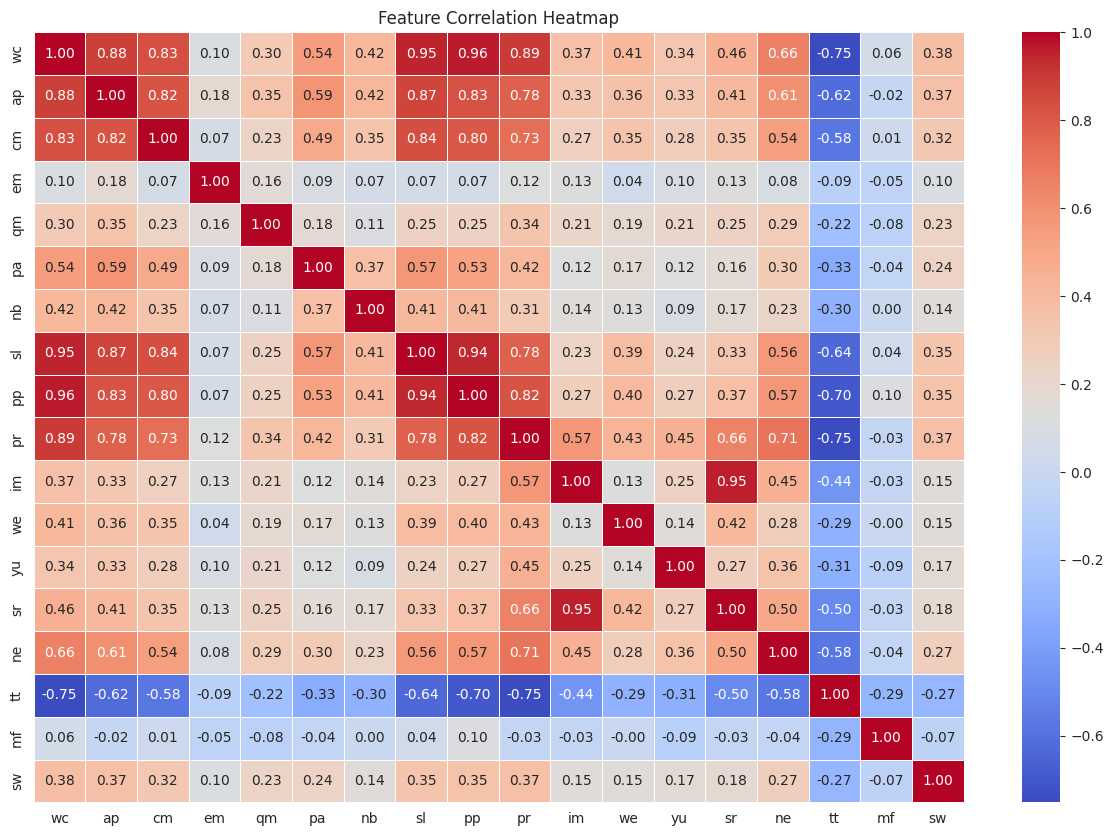

In [4]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.drop(columns=['Rating', 'Sentiment']).corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [5]:
persona_features = df.drop(columns=['Review', 'Rating', 'Sentiment', 'se', 'predicted_genre'])
n_aggregated_features = 8
aggregator = FeatureAgglomeration(n_clusters=n_aggregated_features)
aggregated_features = aggregator.fit_transform(persona_features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(aggregated_features)
print(f"✅ Original features reduced from {persona_features.shape[1]} to {n_aggregated_features} aggregated features.")

✅ Original features reduced from 18 to 8 aggregated features.


## **4. Linguistic Persona Clustering**
### **4.1. Hyperparameter Tuning**
We use the "knee" detection method on the inertia curve to find the optimal number of clusters (`k`).

Finding optimal k in range 2 to 10 using the Knee method...

✅ Optimal k identified at the 'knee': 5


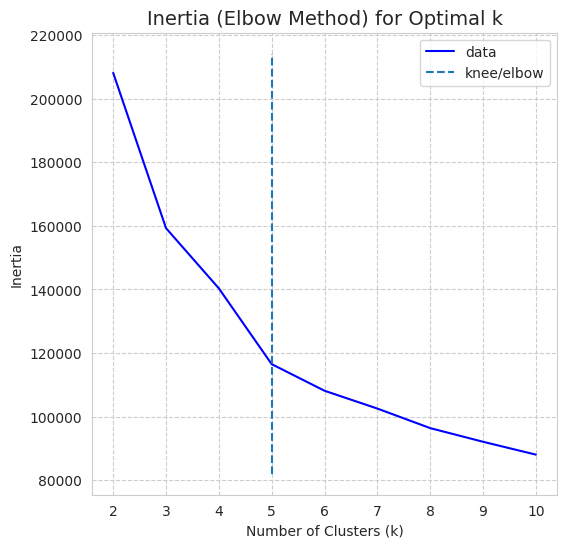

In [6]:
def find_optimal_k_with_knee(X, k_range=range(2, 11)):
    print(f"Finding optimal k in range {k_range.start} to {k_range.stop-1} using the Knee method...")
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    knee_locator = KneeLocator(k_range, inertias, curve='convex', direction='decreasing', S=1.0)
    best_k = knee_locator.elbow
    if best_k is None:
        print("⚠️ Knee not found automatically. Defaulting to k=4.")
        best_k = 4
    else:
        print(f"\n✅ Optimal k identified at the 'knee': {best_k}")
    knee_locator.plot_knee()
    plt.title('Inertia (Elbow Method) for Optimal k', fontsize=14)
    plt.xlabel('Number of Clusters (k)'), plt.ylabel('Inertia'), plt.grid(True, linestyle='--'), plt.show()
    return best_k

best_k = find_optimal_k_with_knee(scaled_features)
if CUML_AVAILABLE:
    scaled_features_gpu = cudf.DataFrame(scaled_features)

### **4.2. Model Fitting**
We fit three clustering models: K-Means, BIRCH, and Gaussian Mixture Models (GMM).

In [7]:
print(f"\nFitting K-Means model with k={best_k}...")
if CUML_AVAILABLE:
    kmeans_model = cuKMeans(n_clusters=int(best_k), random_state=42)
    df['kmeans_cluster'] = kmeans_model.fit_predict(scaled_features_gpu).to_numpy()
else:
    kmeans_model = KMeans(n_clusters=int(best_k), init='k-means++', random_state=42, n_init='auto')
    df['kmeans_cluster'] = kmeans_model.fit_predict(scaled_features)
print("✅ K-Means fitting complete.")

print(f"\nFitting BIRCH model with k={best_k}...")
birch_model = Birch(n_clusters=int(best_k))
df['birch_cluster'] = birch_model.fit_predict(scaled_features)
print("✅ BIRCH fitting complete.")

print(f"\nFitting Gaussian Mixture Model with k={best_k}...")
gmm_model = GaussianMixture(n_components=int(best_k), random_state=42)
df['gmm_cluster'] = gmm_model.fit_predict(scaled_features)
print("✅ GMM fitting complete.")


Fitting K-Means model with k=5...
✅ K-Means fitting complete.

Fitting BIRCH model with k=5...
✅ BIRCH fitting complete.

Fitting Gaussian Mixture Model with k=5...
✅ GMM fitting complete.


## **5. Model Evaluation**
We quantitatively evaluate the models using standard clustering metrics.
- **Silhouette Score:** Higher is better (well-defined clusters).
- **Calinski-Harabasz Score:** Higher is better (dense, well-separated clusters).
- **Davies-Bouldin Index:** Lower is better (less overlap between clusters).

--- Clustering Model Evaluation (Heatmap) ---


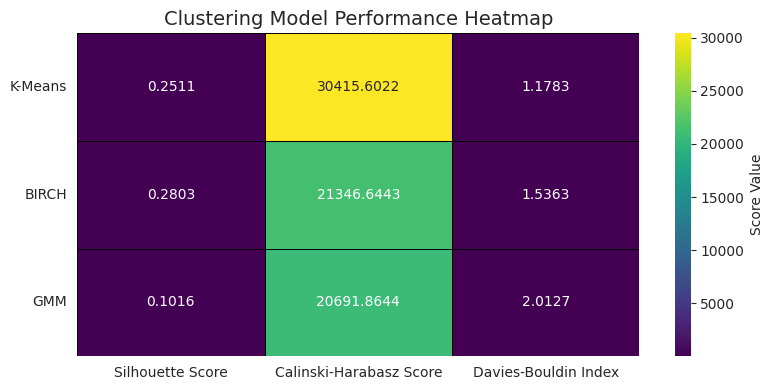

In [8]:
def evaluate_clustering_models(X, labels_dict):
    results_data = []
    model_names = []
    
    for model_name, labels in labels_dict.items():
        # Ensure labels are in the correct format (e.g., a 1D array or Series)
        # If your labels are coming from a DataFrame column, they should be fine.
        # Otherwise, you might need labels.squeeze() or labels.values.flatten()
        
        # Check for sufficient number of samples and clusters for scores
        if len(np.unique(labels)) < 2 or X.shape[0] < 2:
            print(f"Warning: Not enough unique clusters or samples for {model_name}. Skipping scores.")
            sil_score = np.nan
            cal_score = np.nan
            dav_score = np.nan
        else:
            try:
                sil_score = silhouette_score(X, labels)
            except ValueError as e:
                print(f"Error calculating Silhouette Score for {model_name}: {e}")
                sil_score = np.nan
            try:
                cal_score = calinski_harabasz_score(X, labels)
            except ValueError as e:
                print(f"Error calculating Calinski-Harabasz Score for {model_name}: {e}")
                cal_score = np.nan
            try:
                dav_score = davies_bouldin_score(X, labels)
            except ValueError as e:
                print(f"Error calculating Davies-Bouldin Index for {model_name}: {e}")
                dav_score = np.nan
        
        model_names.append(model_name)
        results_data.append([sil_score, cal_score, dav_score])

    # Create a Pandas DataFrame from the results
    df_results = pd.DataFrame(results_data, 
                              index=model_names, 
                              columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Index'])

    print("--- Clustering Model Evaluation (Heatmap) ---")
    
    # Create a NEW figure for the heatmap
    plt.figure(figsize=(8, 4)) 

    sns.heatmap(df_results, 
                annot=True,        # Show the actual scores on the heatmap
                fmt=".4f",         # Format the scores to 4 decimal places
                cmap="viridis",    # Choose a colormap
                linewidths=.5,     # Add lines between cells
                linecolor='black', # Color of the lines
                cbar_kws={'label': 'Score Value'}) # Label for the color bar

    plt.title('Clustering Model Performance Heatmap', fontsize=14)
    plt.yticks(rotation=0) # Ensure model names are horizontal
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show() # Display the heatmap


model_labels = {
    "K-Means": df['kmeans_cluster'],
    "BIRCH": df['birch_cluster'],
    "GMM": df['gmm_cluster']
}

evaluate_clustering_models(scaled_features, model_labels)

## **6. Persona Naming**
We manually assign a descriptive name to each persona based on random samples collected by a simple script, allowing for qualitative analysis of each group's characteristics.

In [9]:
def get_cluster_samples(df_main: pd.DataFrame, model_name: str, cluster_id: int) -> None:
    cluster_col_map = {
        'kmeans': 'kmeans_cluster',
        'birch': 'birch_cluster',
        'gmm': 'gmm_cluster'
    }

    # Normalize model_name input for consistent lookup
    model_key = model_name.lower().replace('-', '')

    if model_key not in cluster_col_map:
        print(f"Error: Model '{model_name}' not recognized. Please choose from K-Means, BIRCH, or GMM.")
        return

    cluster_column = cluster_col_map[model_key]

    if cluster_column not in df_main.columns:
        print(f"Error: Cluster column '{cluster_column}' not found in the DataFrame.")
        print(f"Available cluster columns: {[col for col in df_main.columns if '_cluster' in col]}")
        return

    persona_data = df_main[(df_main[cluster_column] == cluster_id)]

    if persona_data.empty:
        print(f"No reviews found for Cluster {cluster_id} in the {model_name} model.")
        return

    print(f"--- Sample Reviews for Cluster {cluster_id} ({model_name} Model) ---")
    print(f"Total reviews in this cluster: {len(persona_data)}")
    print(f"Avg. Rating: {persona_data['Rating'].mean():.2f}/10")
    sentiment_dist = persona_data['Sentiment'].value_counts(normalize=True)
    print(f"Sentiment: {sentiment_dist.get('positive', 0):.1%} Positive / {sentiment_dist.get('negative', 0):.1%} Negative")
    top_genres = persona_data['predicted_genre'].value_counts().nlargest(3)
    print("\n[--- Top 3 Genres ---]")
    for genre, count in top_genres.items(): print(f"- {genre} ({count} reviews)")
    print("-" * 70)

    # Display up to 5 random samples
    sample_size = min(5, len(persona_data))
    sample_data = persona_data.sample(n=sample_size, random_state=42) # Use random_state for reproducibility

    print("\n[--- Sample Reviews ---]")
    for _, row in sample_data.iterrows():
        print("----------------------------------------------------------------------")
        print(f"Rating: {row['Rating']}/10 | Sentiment: {row['Sentiment']}")
        print(f"Review: {row['Review']}")
    print("----------------------------------------------------------------------")

# while True:
#     clear_output(wait=True)
#     print("--- Get Review Samples ---")
#     print("Enter the model and cluster ID (e.g., 'K-Means|0', 'BIRCH|3', 'GMM|1')")
#     print("Type 'exit' to quit.")

#     user_input = input("Your choice: ").strip().lower()

#     if user_input == 'exit':
#         print("Exiting sample viewer. Goodbye!")
#         break

#     parts = user_input.split('|')
#     if len(parts) != 2:
#         print("Invalid format. Please use 'ModelName|ClusterID' (e.g., 'K-Means|0').")
#         input("Press Enter to try again...")
#         continue

#     model_input = parts[0].strip()
#     try:
#         cluster_id_input = int(parts[1].strip())
#     except ValueError:
#         print("Invalid Cluster ID. Please ensure it's a number.")
#         input("Press Enter to try again...")
#         continue

#     get_cluster_samples(df, model_input, cluster_id_input)
#     input("\nPress Enter to view more samples or exit...")

In [10]:
kmeans_persona_names = {0: 'emotional', 1: 'flaw ranter', 2: 'academic dissector', 3: 'structured critic', 4: 'candid'}
birch_persona_names = {0: 'academic dissector', 1: 'emotional', 2: 'flaw ranter', 3: 'academic dissector', 4: 'structured critic'}
gmm_persona_names = {0: 'structured critic', 1:'flaw ranter', 2: 'academic dissector', 3: 'academic dissector', 4: 'emotional'}

df['kmeans_persona'] = df['kmeans_cluster'].map(kmeans_persona_names)
df['birch_persona'] = df['birch_cluster'].map(birch_persona_names)
df['gmm_persona'] = df['gmm_cluster'].map(gmm_persona_names)

print("\n--- Final Persona Names ---")
print("K-Means:", kmeans_persona_names)
print("BIRCH:", birch_persona_names)
print("GMM:", gmm_persona_names)


--- Final Persona Names ---
K-Means: {0: 'emotional', 1: 'flaw ranter', 2: 'academic dissector', 3: 'structured critic', 4: 'candid'}
BIRCH: {0: 'academic dissector', 1: 'emotional', 2: 'flaw ranter', 3: 'academic dissector', 4: 'structured critic'}
GMM: {0: 'structured critic', 1: 'flaw ranter', 2: 'academic dissector', 3: 'academic dissector', 4: 'emotional'}


# **ANALYSIS & FINDINGS**
With our models trained and personas named, we can now perform a deep, comparative analysis. A master color palette is created here to ensure that each persona retains the same color across all subsequent visualizations, providing a clear and consistent visual narrative.

In [11]:
# --- Master Color Palette Generation ---
# Create a superset of all unique persona names from all models
all_persona_names = set(kmeans_persona_names.values()) | \
                    set(birch_persona_names.values()) | \
                    set(gmm_persona_names.values())

# Generate a unique, consistent color for each unique persona name
palette = sns.color_palette('Accent', n_colors=len(all_persona_names))
master_color_map = dict(zip(sorted(list(all_persona_names)), palette))

print("--- Master Color Map Generated ---")
# Display the color mapping for reference
for name, color in master_color_map.items():
    display(HTML(f"<span style='color:rgb({color[0]*255},{color[1]*255},{color[2]*255}); font-weight:bold;'>■</span> {name}"))

--- Master Color Map Generated ---


## **1. Cluster Visualization with UMAP**
We use UMAP to visualize the high-dimensional linguistic feature space in 2D. The consistent color scheme allows for easy visual tracking of personas.

Generating UMAP for: 2D UMAP of K-Means Personas (k=5)


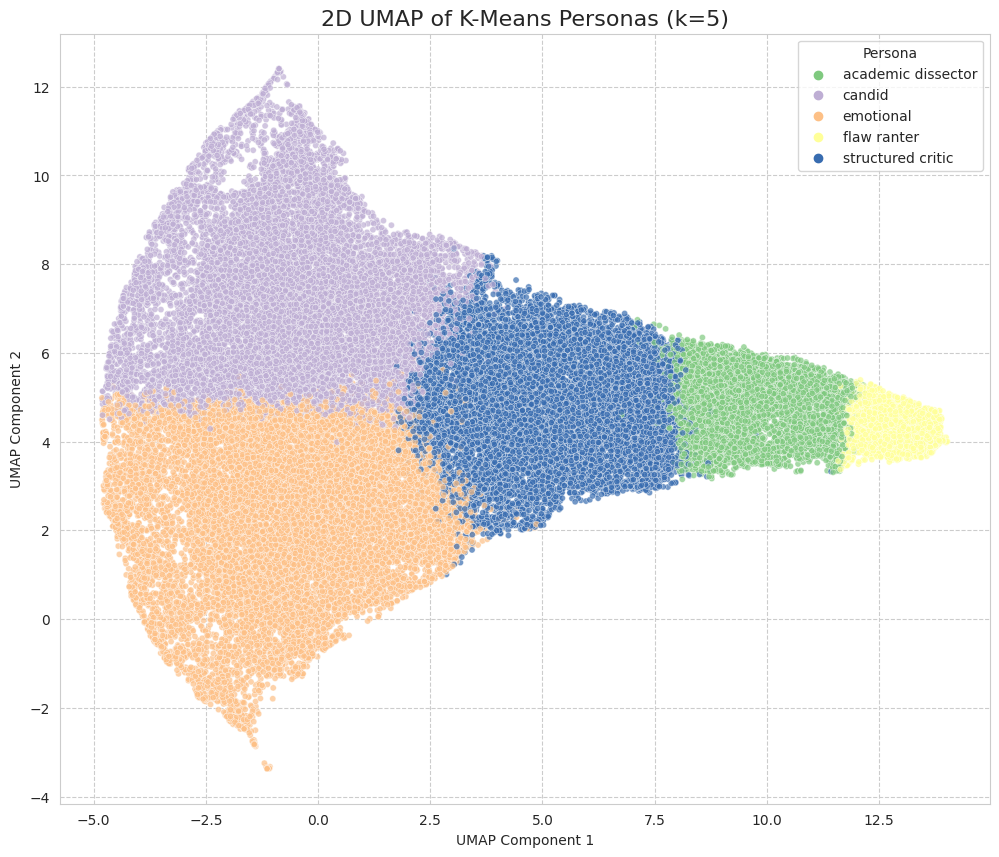

Generating UMAP for: 2D UMAP of BIRCH Personas (k=5)


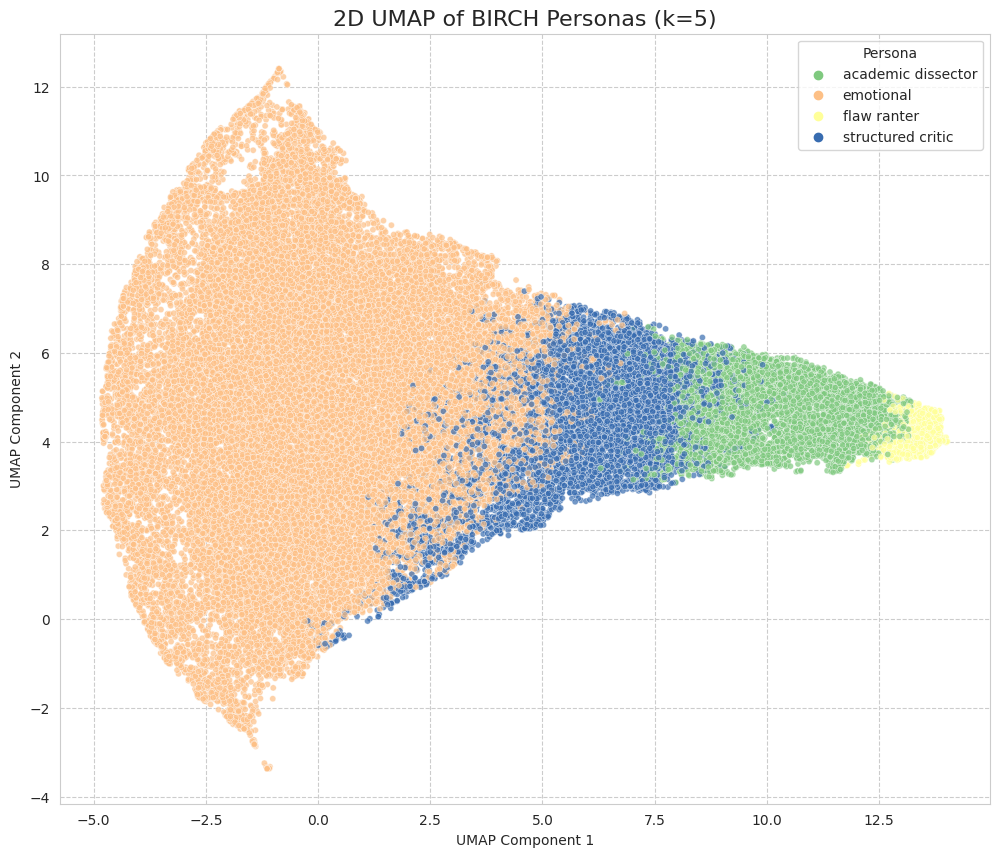

Generating UMAP for: 2D UMAP of GMM Personas (k=5)


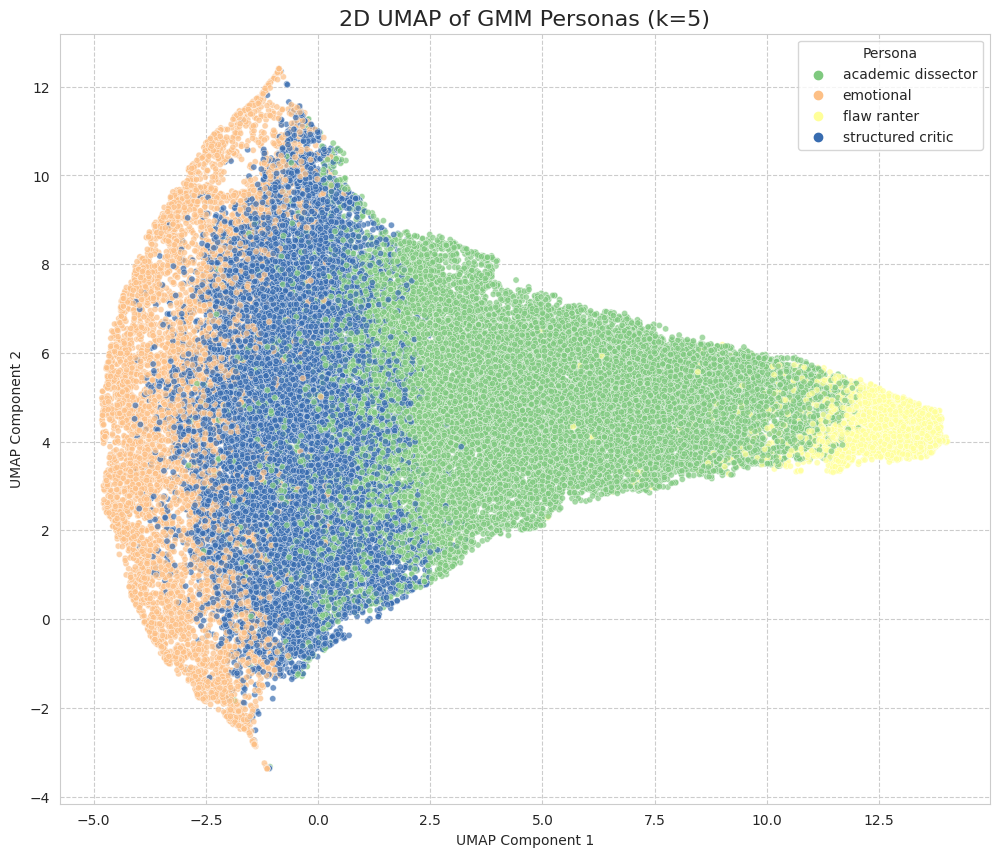

In [12]:
def visualize_clusters_2d_umap(X, labels, title, persona_names_map, color_map):
    """Reduces features to 2D with UMAP and plots the clusters with consistent colors."""
    print(f"Generating UMAP for: {title}")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(X)

    plot_df = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
    plot_df['Persona'] = pd.Series(labels).map(persona_names_map)

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=plot_df,
        x='UMAP 1',
        y='UMAP 2',
        hue='Persona',
        hue_order=sorted(plot_df['Persona'].unique()), # Ensure legend is alphabetical
        palette=color_map, # Apply the master color map
        s=20,
        alpha=0.7
    )
    plt.title(title, fontsize=16)
    plt.xlabel('UMAP Component 1'), plt.ylabel('UMAP Component 2')
    plt.legend(title='Persona'), plt.grid(True, linestyle='--'), plt.show()

# --- Visualize all model results with consistent coloring ---
visualize_clusters_2d_umap(scaled_features, df['kmeans_cluster'], f'2D UMAP of K-Means Personas (k={best_k})', kmeans_persona_names, master_color_map)
visualize_clusters_2d_umap(scaled_features, df['birch_cluster'], f'2D UMAP of BIRCH Personas (k={best_k})', birch_persona_names, master_color_map)
visualize_clusters_2d_umap(scaled_features, df['gmm_cluster'], f'2D UMAP of GMM Personas (k={best_k})', gmm_persona_names, master_color_map)

## **2. Comparative Analysis of Persona Characteristics**
### **2.1. Linguistic Profiles (Radar Charts)**
Radar charts visualize the defining linguistic traits of each persona. Each persona's profile is rendered in its assigned color, making it easy to cross-reference with other charts.

In [13]:
def plot_persona_radar_charts(df_features, df_clusters, model_name, persona_names_map, color_map):
    """Generates radar charts with consistent persona colors."""
    persona_col = f'{model_name.lower()}_persona'
    df_plot_data = pd.concat([df_clusters[persona_col], pd.DataFrame(StandardScaler().fit_transform(df_features), columns=df_features.columns)], axis=1)
    centroids = df_plot_data.groupby(persona_col).mean()
    centroids = centroids.sort_index() # Sort to match color map order if needed

    labels, num_vars = centroids.columns, len(centroids.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    fig = go.Figure()

    for persona_name, row in centroids.iterrows():
        values = row.values.tolist() + [row.values[0]]
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=labels,
            fill='toself',
            name=str(persona_name),
            # Explicitly set the color for this persona's trace
            line=dict(color=f'rgb({color_map[persona_name][0]*255},{color_map[persona_name][1]*255},{color_map[persona_name][2]*255})')
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[centroids.min().min() - 0.1, centroids.max().max() + 0.1])),
        showlegend=True,
        title=f'Linguistic Profile Radar Chart for {model_name} Personas',
        title_x=0.5,
        height=700
    )
    fig.show()

# --- Generate Radar Charts with consistent coloring ---
plot_persona_radar_charts(persona_features, df, 'KMeans', kmeans_persona_names, master_color_map)
plot_persona_radar_charts(persona_features, df, 'BIRCH', birch_persona_names, master_color_map)
plot_persona_radar_charts(persona_features, df, 'GMM', gmm_persona_names, master_color_map)

### **2.2. Persona Distribution across Movie Genres**
A heatmap reveals the relationship between linguistic personas and the movie genres they review. (Note: Heatmap colors represent value, not persona categories).

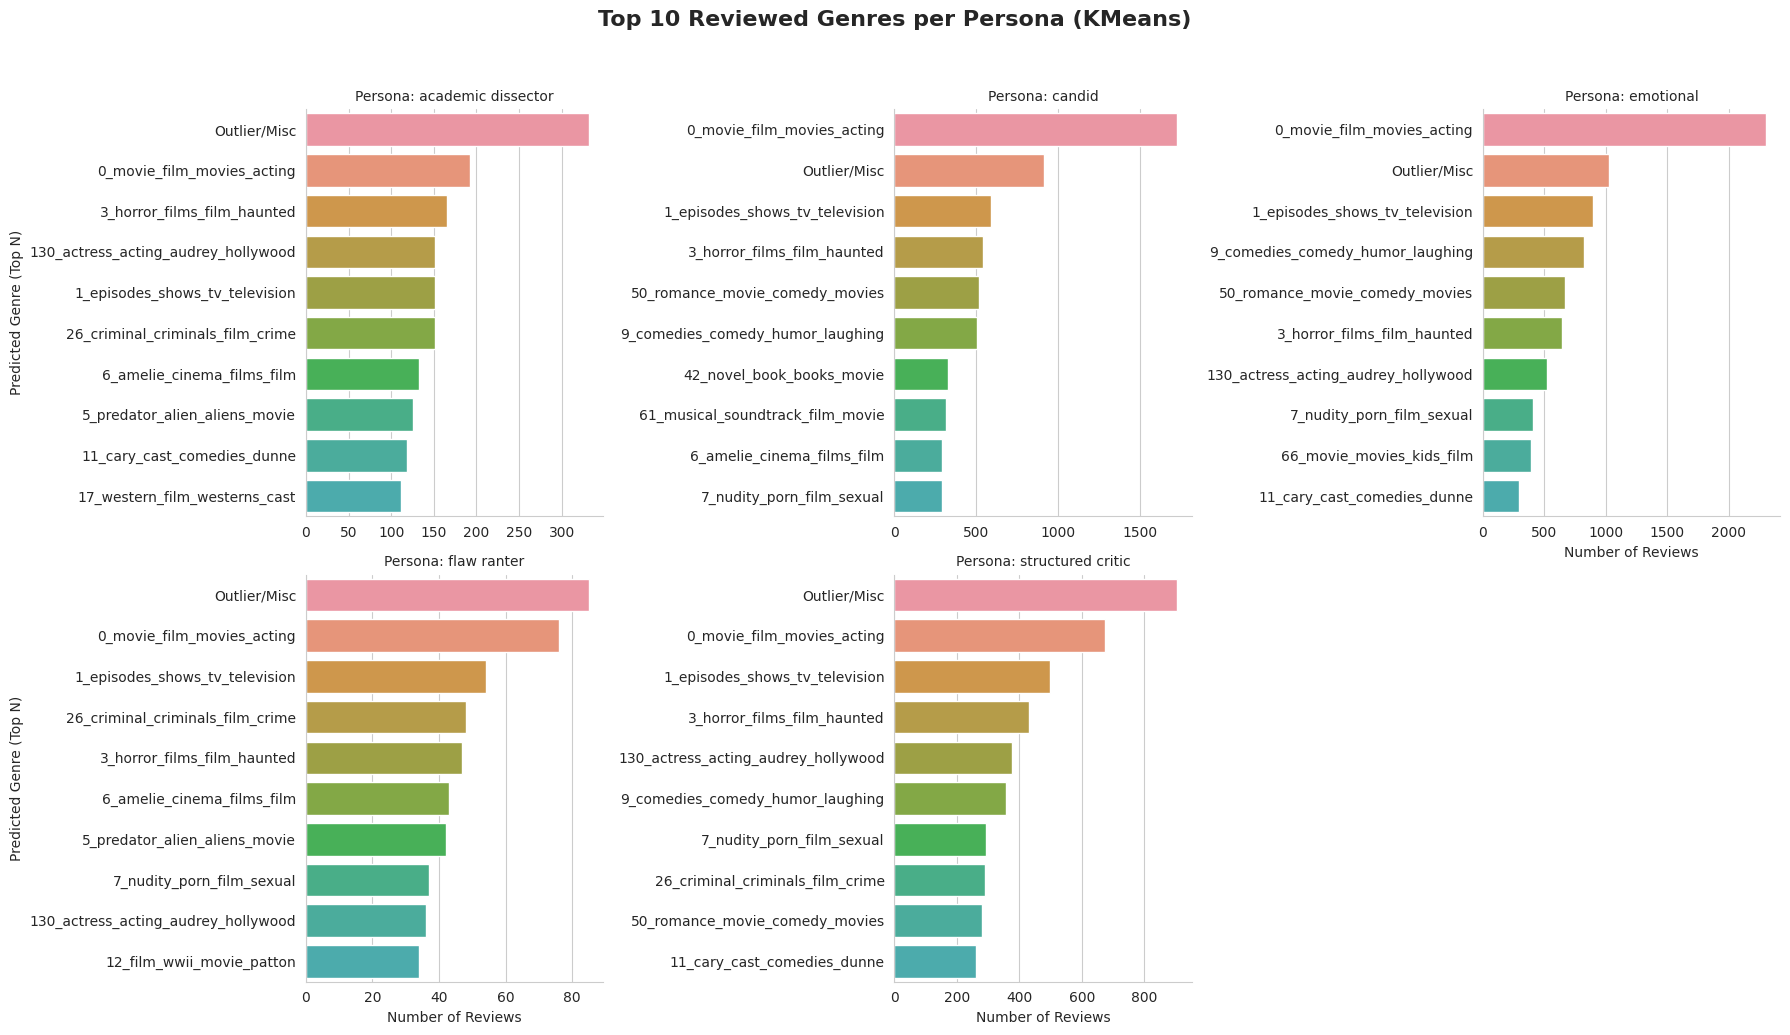

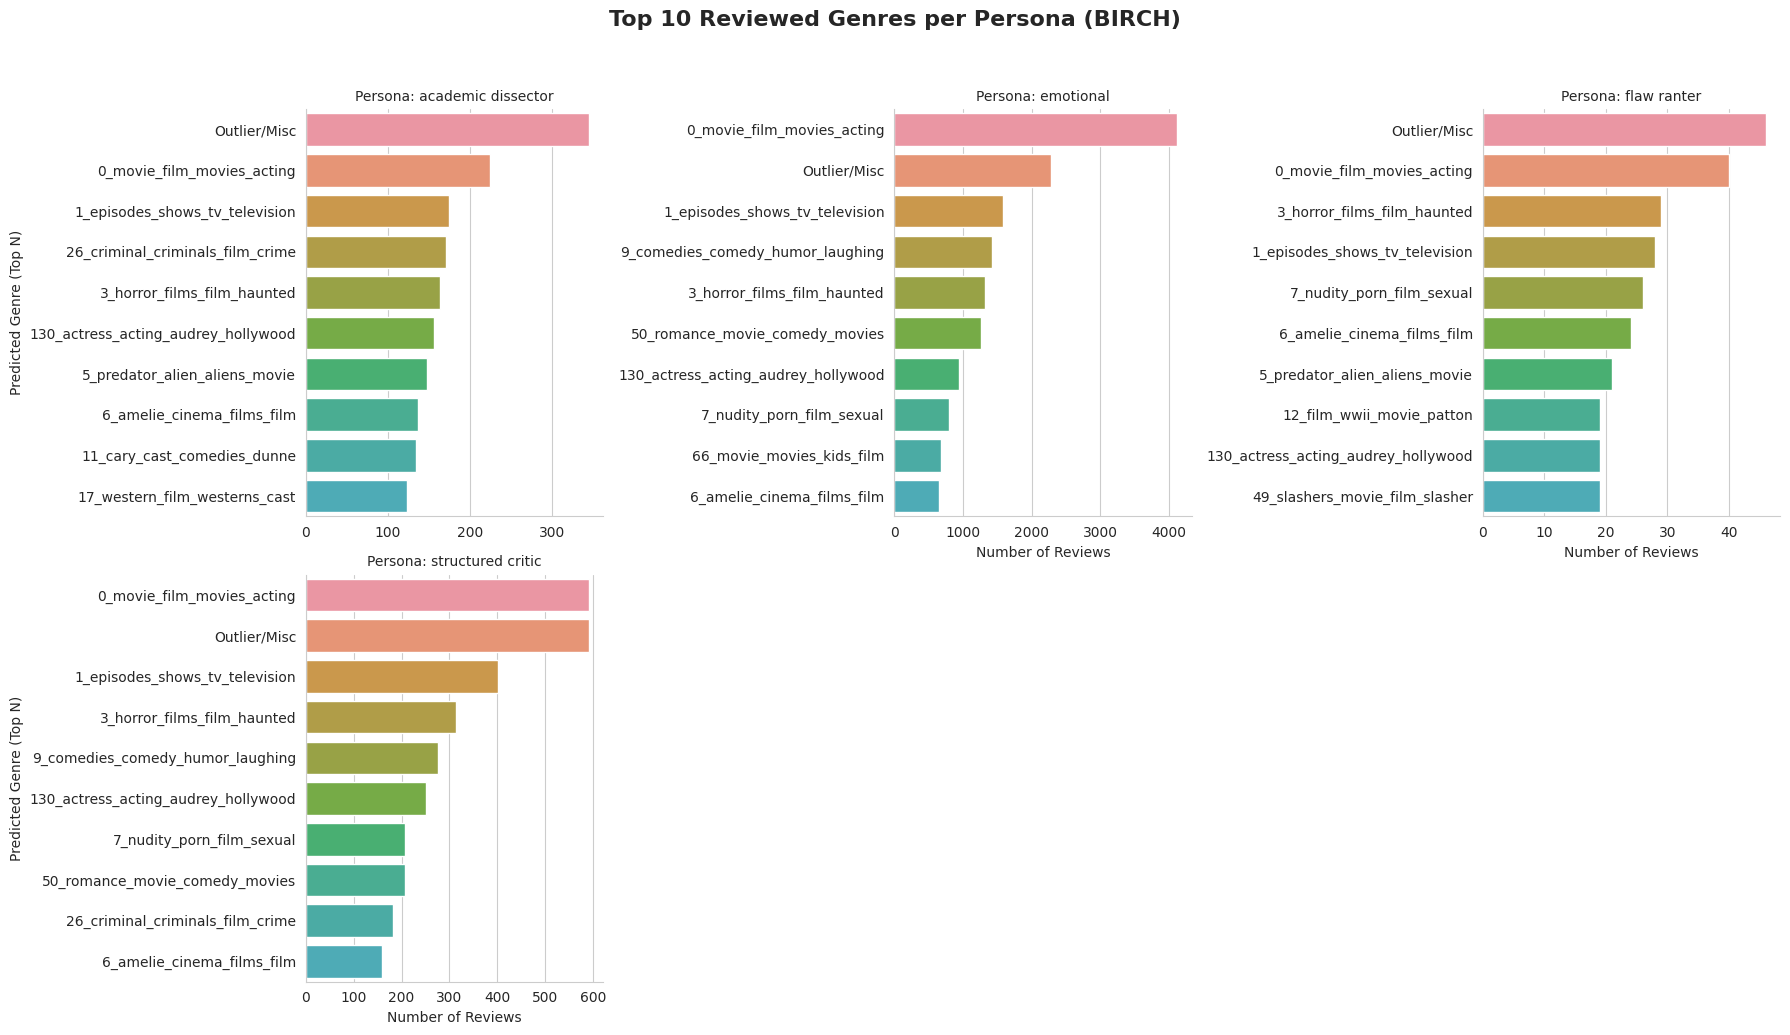

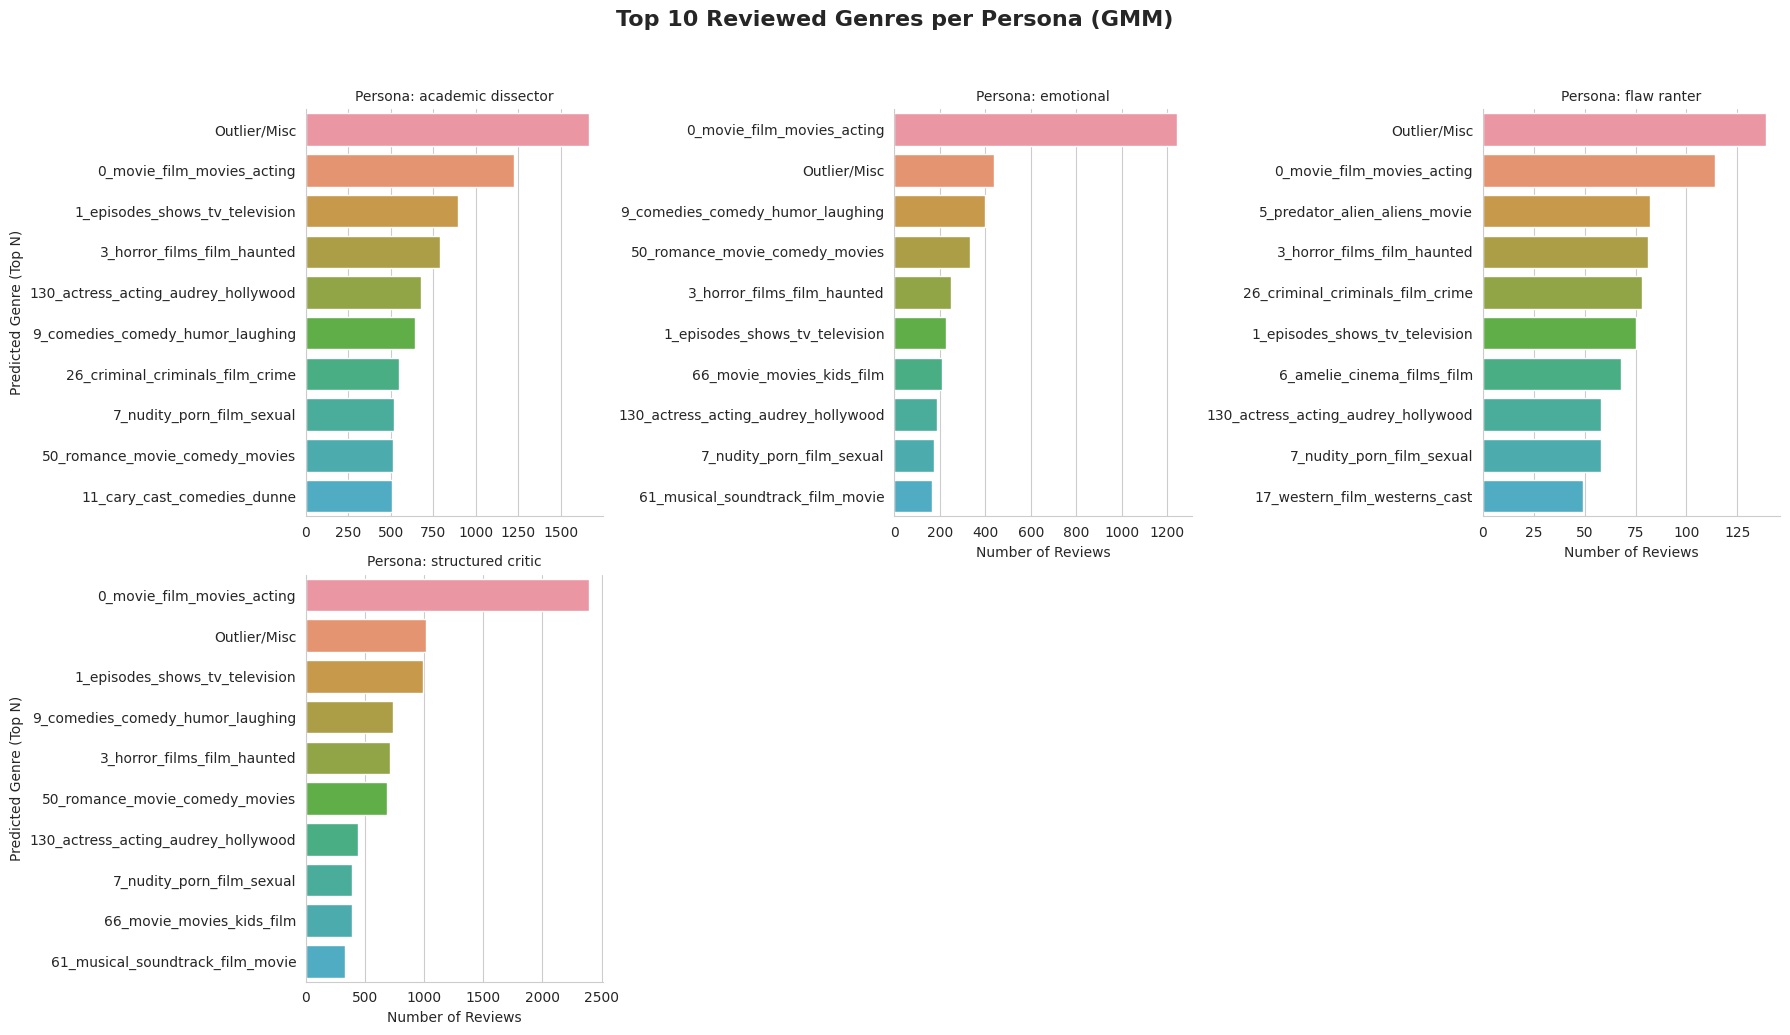

In [17]:
def plot_persona_genre(df_analysis, model_name, top_n=10):
    persona_col = f'{model_name.lower()}_persona'

    plot_data = df_analysis.groupby([persona_col, 'predicted_genre']).size().reset_index(name='count')
    
    plot_data = plot_data.groupby(persona_col).apply(lambda x: x.nlargest(top_n, 'count')).reset_index(drop=True)

    g = sns.catplot(
        data=plot_data,
        x='count',
        y='predicted_genre',
        col=persona_col,
        kind='bar',
        col_wrap=3,
        sharex=False,
        sharey=False,
        height=5,
        aspect=1.2
    )
    
    g.fig.suptitle(f'Top {top_n} Reviewed Genres per Persona ({model_name})', y=1.03, fontsize=16, weight='bold')
    g.set_titles("Persona: {col_name}")
    g.set_xlabels("Number of Reviews")
    g.set_ylabels("Predicted Genre (Top N)")
    plt.tight_layout()
    plt.show()

plot_persona_genre(df, 'KMeans')
plot_persona_genre(df, 'BIRCH')
plot_persona_genre(df, 'GMM')

### **2.3. Persona Rating Behavior**
Violin plots illustrate how different personas distribute their ratings. Each violin is shaded with the persona's assigned color for immediate identification.

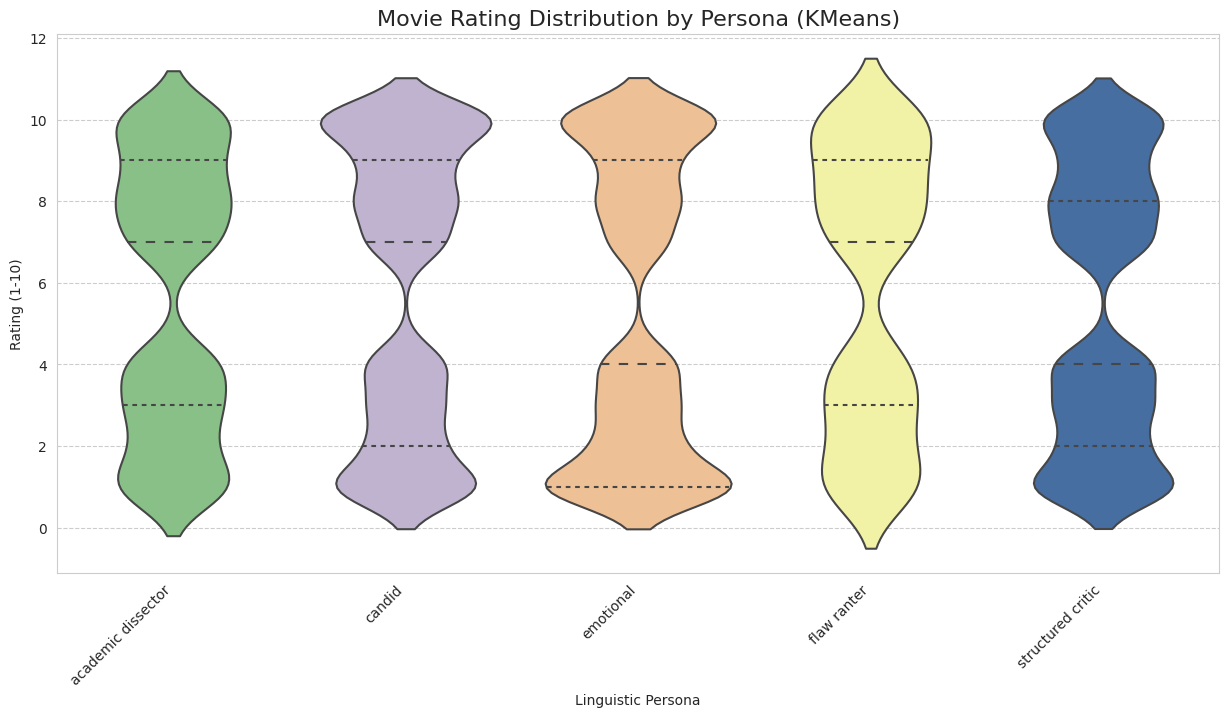

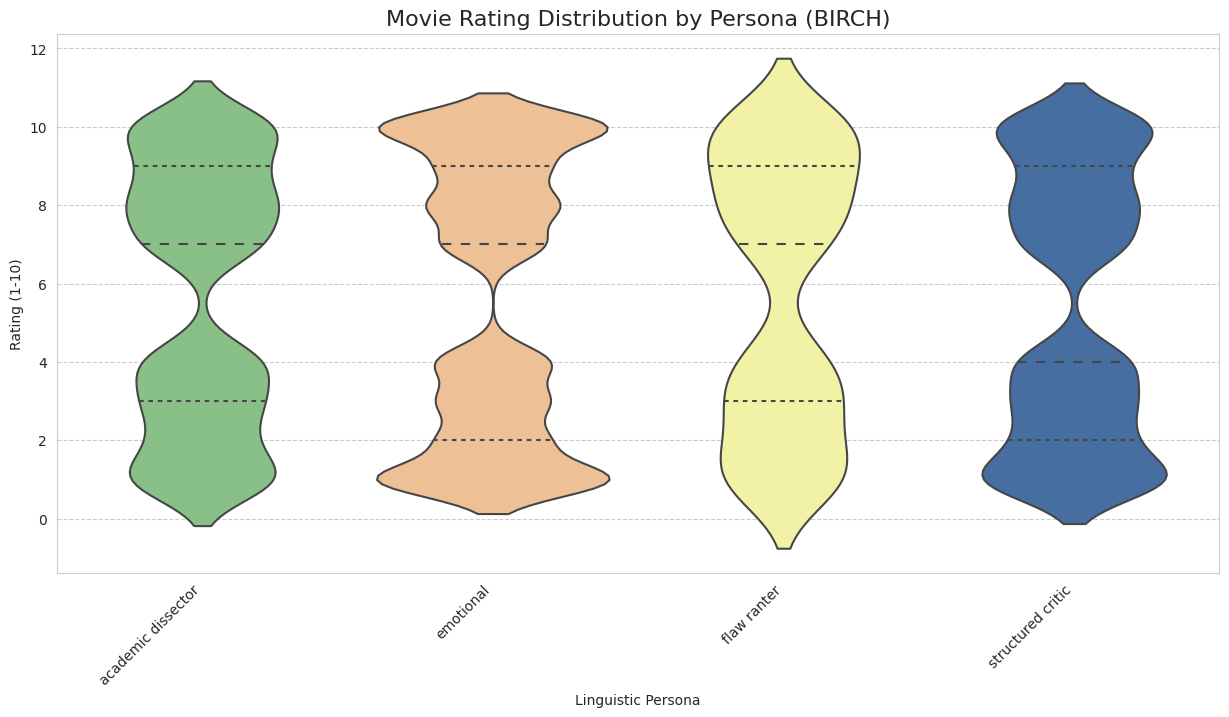

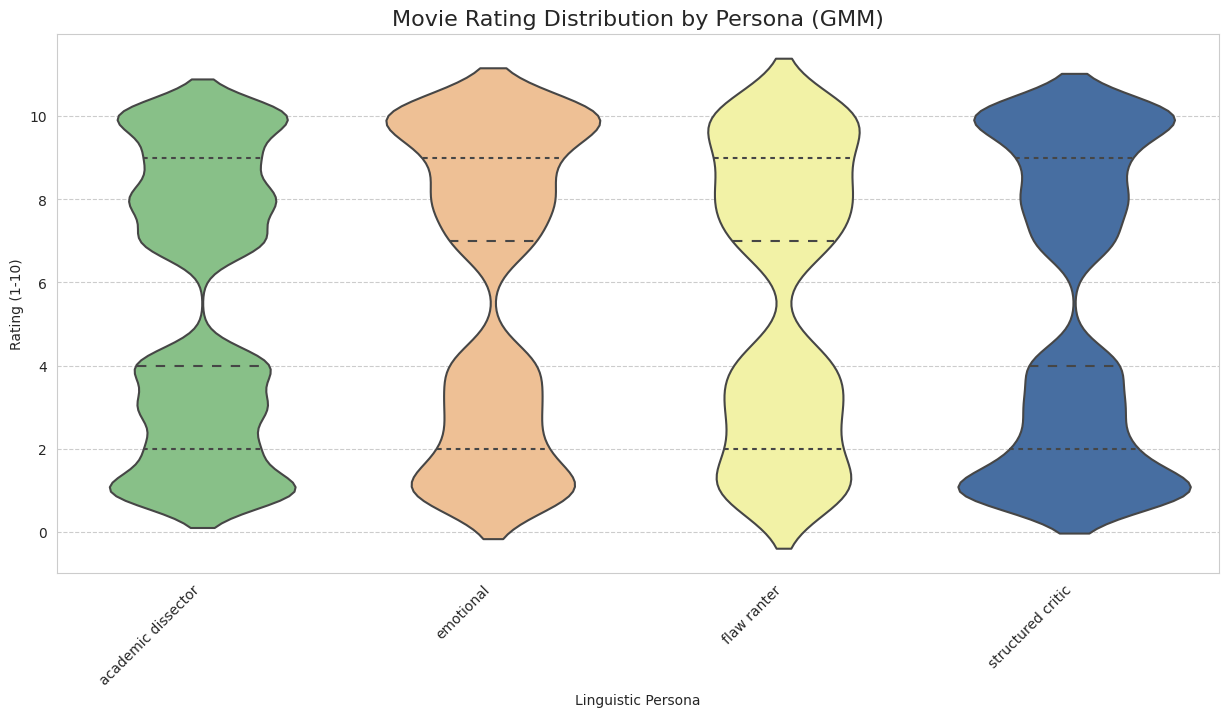

In [15]:
def plot_persona_rating_distribution(df_analysis, model_name, color_map):
    """Creates violin plots with consistent persona colors."""
    persona_col = f'{model_name.lower()}_persona'
    order = sorted(df_analysis[persona_col].unique()) # Alphabetical order
    plt.figure(figsize=(15, 7))
    sns.violinplot(
        x=persona_col,
        y='Rating',
        data=df_analysis,
        order=order,
        palette=color_map, # Apply the master color map
        inner='quartile'
    )
    plt.title(f'Movie Rating Distribution by Persona ({model_name})', fontsize=16)
    plt.xlabel('Linguistic Persona'), plt.ylabel('Rating (1-10)'), plt.xticks(rotation=45, ha='right'), plt.show()

# --- Generate Violin Plots with consistent coloring ---
plot_persona_rating_distribution(df, 'KMeans', master_color_map)
plot_persona_rating_distribution(df, 'BIRCH', master_color_map)
plot_persona_rating_distribution(df, 'GMM', master_color_map)

### **2.4. Persona Sentiment Breakdown**
To further understand the critical tendencies of each persona, we can visualize the precise breakdown of positive versus negative sentiment within each group. A stacked bar chart provides a clear, at-a-glance comparison, revealing which personas are inherently more critical or more prone to praise.

--- Generating Persona Sentiment Breakdown Charts ---


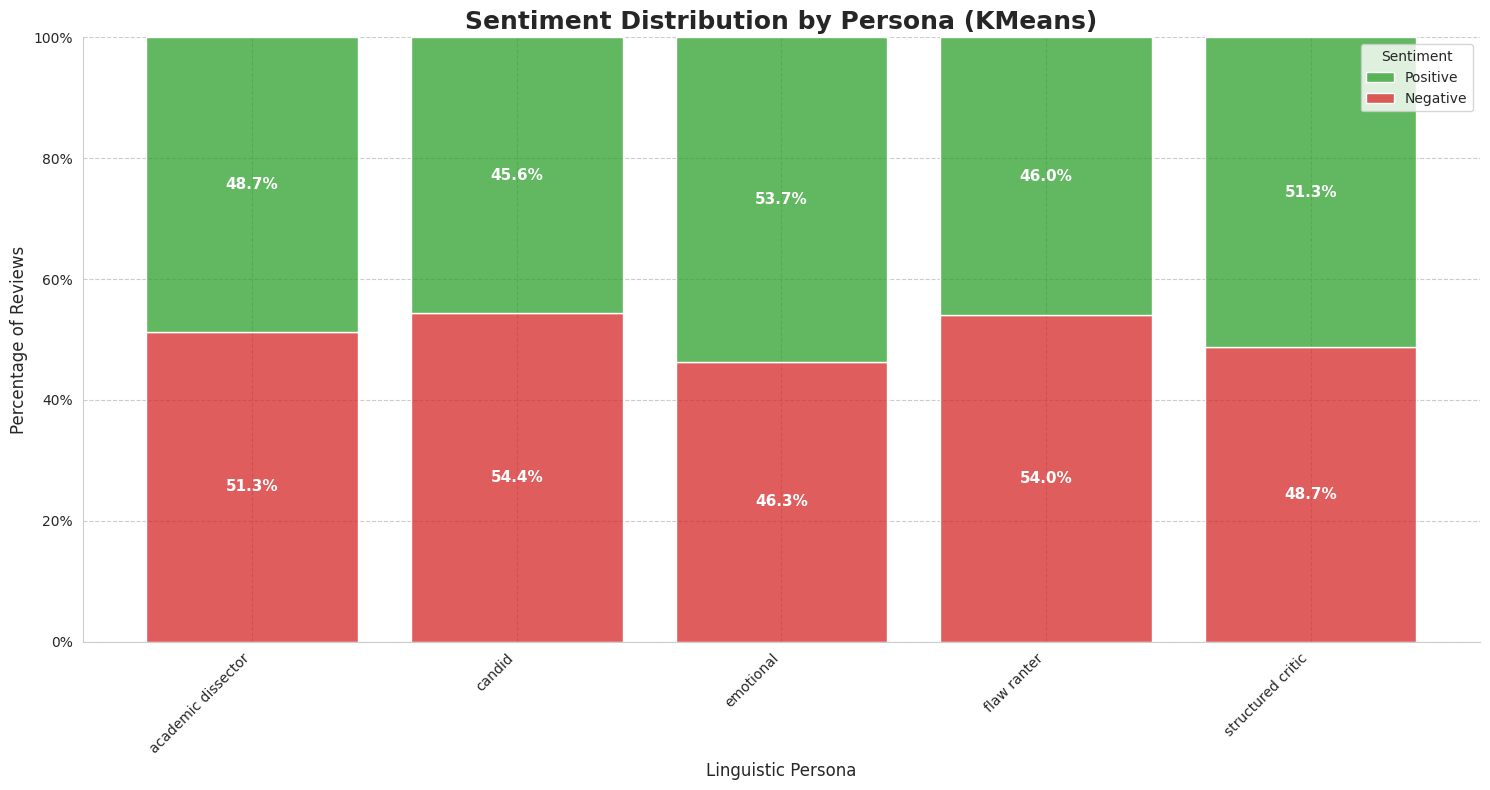

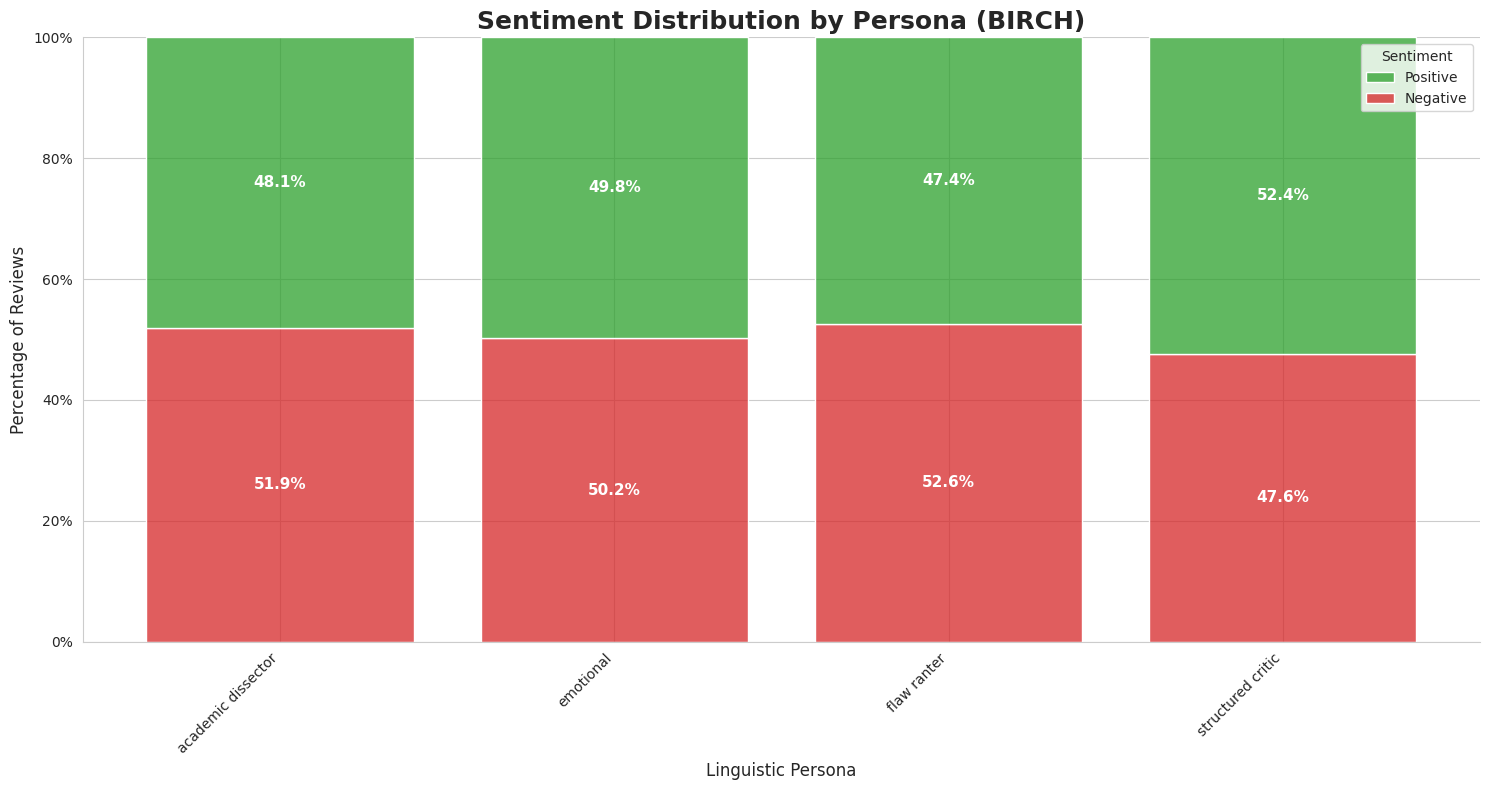

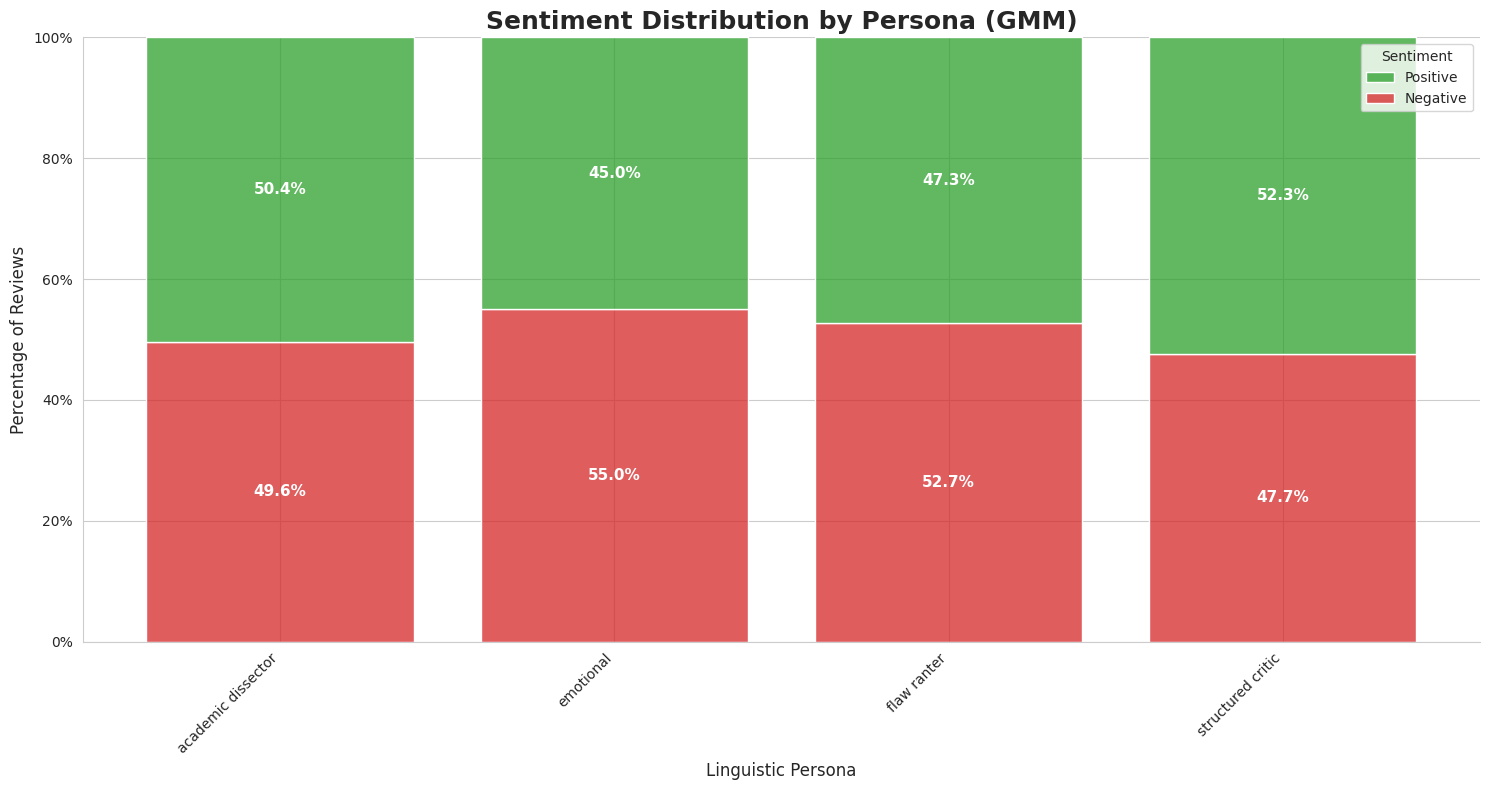

In [16]:
def plot_persona_sentiment_distribution_sns(df_analysis, model_name):
    """
    Creates an aesthetic stacked bar chart using Seaborn to show the
    sentiment distribution (positive/negative) for each persona.
    """
    persona_col = f'{model_name.lower()}_persona'

    # --- 1. Data Preparation ---
    # Calculate the percentage of positive/negative reviews for each persona
    crosstab = pd.crosstab(df_analysis[persona_col], df_analysis['Sentiment'], normalize='index') * 100

    # Convert from wide to long format, which is ideal for Seaborn
    plot_data = crosstab.stack().reset_index(name='Percentage')
    plot_data = plot_data.sort_values(by=persona_col) # Sort for consistent order

    # --- 2. Plotting with Seaborn ---
    # Define consistent colors for sentiment
    sentiment_colors = {0: '#2ca02c', 1: '#d62728'}

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.set_style("whitegrid")

    # Use sns.histplot which can create stacked bars from weighted long-form data
    sns.histplot(
        data=plot_data,
        x=persona_col,
        hue='Sentiment',
        weights='Percentage', # Key: bar height is determined by the Percentage column
        multiple='stack',
        palette=sentiment_colors,
        ax=ax,
        shrink=0.8 # Adds a little space between bars
    )

    # --- 3. Formatting for Clarity and Aesthetics ---
    plt.title(f'Sentiment Distribution by Persona ({model_name})', fontsize=18, weight='bold')
    plt.xlabel('Linguistic Persona', fontsize=12)
    plt.ylabel('Percentage of Reviews', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Format Y-axis ticks as percentages
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
    ax.set_ylim(0, 100)

    # --- Corrected Legend Handling ---
    # Get the handles from the legend that seaborn automatically creates
    handles = ax.legend_.legend_handles
    # Set the new labels for the legend
    ax.legend(handles, ['Positive', 'Negative'], title='Sentiment', loc='upper right')

    # Add percentage labels inside the bars
    for c in ax.containers:
        # Filter out labels for very small segments to avoid clutter
        labels = [f'{w:.1f}%' if w > 4 else '' for w in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', color='white', weight='bold', fontsize=11)

    # Remove top and right spines for a cleaner look
    sns.despine()
    plt.tight_layout()
    plt.show()

# --- Generate Sentiment Breakdown Charts for all Models ---
print("--- Generating Persona Sentiment Breakdown Charts ---")
plot_persona_sentiment_distribution_sns(df, 'KMeans')
plot_persona_sentiment_distribution_sns(df, 'BIRCH')
plot_persona_sentiment_distribution_sns(df, 'GMM')